In [3]:
#!pip install plotly
#!pip install cufflinks
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
#from keras.layers.normalization import BatchNormalization
from keras.layers import LayerNormalization

from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
train = pd.read_csv('jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')
display(train.head())
train['comment_text']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
223544    :Jerome, I see you never got around to this…! ...
223545    ==Lucky bastard== \n http://wikimediafoundatio...
223546    ==shame on you all!!!== \n\n You want to speak...
223547    MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
223548    " \n\n == Unicorn lair discovery == \n\n Suppo...
Name: comment_text, Length: 223549, dtype: object

In [6]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [7]:
train.shape

(223549, 3)

In [8]:
train['toxic'].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

In [9]:
train.head()
train['toxic']

0         0
1         0
2         0
3         0
4         0
         ..
223544    0
223545    0
223546    0
223547    1
223548    0
Name: toxic, Length: 223549, dtype: int64

In [10]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [11]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
#(xtrain)

In [12]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 2400

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
print(xtrain_seq[0])

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index
print(xtrain_pad[0])


[80, 6, 1619, 266, 11, 73, 2, 37, 1, 1572, 2508, 76, 1350, 2, 1, 1572, 3, 82, 1, 23, 111, 24, 415, 1, 108, 6, 550, 11, 80, 6, 1619, 266, 11, 73, 2, 37, 584, 7, 79, 14, 2288, 54, 29, 408]
[  0   0   0 ...  54  29 408]


In [13]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2400, 300)         90077400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 90,117,601
Trainable params: 90,117,601
Non-trainable params: 0
_________________________________________________________________
Wall time: 2.33 s


In [14]:
model.fit(xtrain_pad, ytrain, epochs=1, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

2795/2795 [==============================] - 8163s 3s/step - loss: 0.2292 - accuracy: 0.9207


In [34]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.94%


In [35]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

In [36]:
xtrain_seq[:1]


[[80,
  6,
  1619,
  266,
  11,
  73,
  2,
  37,
  1,
  1572,
  2508,
  76,
  1350,
  2,
  1,
  1572,
  3,
  82,
  1,
  23,
  111,
  24,
  415,
  1,
  108,
  6,
  550,
  11,
  80,
  6,
  1619,
  266,
  11,
  73,
  2,
  37,
  584,
  7,
  79,
  14,
  2288,
  54,
  29,
  408]]

In [38]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('C:/Users/Riswin/Desktop/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [02:10, 16814.76it/s]

Found 2196017 word vectors.


In [39]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 300257/300257 [00:02<00:00, 126340.25it/s]


In [43]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2400, 300)         90077400  
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 90,147,651
Trainable params: 70,251
Non-trainable params: 90,077,400
_________________________________________________________________
CPU times: user 378 ms, sys: 557 ms, total: 936 ms
Wall time: 1.63 s


In [44]:
model.fit(xtrain_pad, ytrain, epochs=1, batch_size=64)

ResourceExhaustedError:  OOM when allocating tensor with shape[64,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/lstm_1/while/lstm_cell_1/dropout_2/random_uniform/RandomUniform
 (defined at /home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py:5251)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28423]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_2/lstm_1/while/lstm_cell_1/dropout_2/random_uniform/RandomUniform:
In[0] sequential_2/lstm_1/while/lstm_cell_1/dropout_2/Shape:

Operation defined at: (most recent call last)
>>>   File "/home/sudipta/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
>>>     yield self.process_one()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 250, in wrapper
>>>     runner = Runner(ctx_run, result, future, yielded)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 741, in __init__
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-44-0aee8a7b73b1>", line 1, in <module>
>>>     model.fit(xtrain_pad, ytrain, epochs=1, batch_size=64)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 679, in __call__
>>>     return super(RNN, self).__call__(inputs, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2826, in call
>>>     return super(LSTM, self).call(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 816, in call
>>>     last_output, outputs, states = backend.rnn(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4654, in rnn
>>>     final_outputs = tf.compat.v1.while_loop(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4640, in _step
>>>     output, new_states = step_function(current_input,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 812, in step
>>>     output, new_states = cell_call_fn(inputs, states, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2449, in call
>>>     dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 1215, in get_dropout_mask_for_cell
>>>     return self._dropout_mask_cache.setdefault(kwargs=init_kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 6772, in setdefault
>>>     default = self.default_factory(**kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 1183, in _create_dropout_mask
>>>     return _generate_dropout_mask(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2953, in _generate_dropout_mask
>>>     return [
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2954, in <listcomp>
>>>     backend.in_train_phase(dropped_inputs, ones, training=training)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 4782, in in_train_phase
>>>     return x()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2950, in dropped_inputs
>>>     return backend.dropout(ones, rate)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5251, in dropout
>>>     return tf.nn.dropout(x, rate=level, noise_shape=noise_shape, seed=seed)
>>> 

Function call stack:
train_function -> sequential_2_lstm_1_while_body_26358_rewritten


In [48]:
#! pip install kaggle_datasets
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
! pip install transformers
import transformers

from tokenizers import BertWordPieceTokenizer


     |████████████████████████████████| 3.1 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 16.8 MB/s eta 0:00:01
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
     |████████████████████████████████| 59 kB 7.9 MB/s  eta 0:00:01


In [53]:
# LOADING THE DATA

train1 = pd.read_csv('jigsaw-toxic-comment-train.csv')
valid = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [64]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [55]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 1
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [56]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [65]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

100%|██████████| 250/250 [00:03<00:00, 82.45it/s]


In [66]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [67]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [68]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  134734080
 tilBertModel)               idden_state=(None, 192,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 769       
                                                             

/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [69]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

ResourceExhaustedError:  failed to allocate memory
	 [[node Adam/Adam/update/mul_1
 (defined at /home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:201)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_42911]

Errors may have originated from an input operation.
Input Source operations connected to node Adam/Adam/update/mul_1:
In[0] Adam/Adam/update/ReadVariableOp:	
In[1] Adam/Identity_1 (defined at /home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:128)

Operation defined at: (most recent call last)
>>>   File "/home/sudipta/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-69-3126dede9bb1>", line 2, in <module>
>>>     train_history = model.fit(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 532, in minimize
>>>     return self.apply_gradients(grads_and_vars, name=name)
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 672, in apply_gradients
>>>     return self._distributed_apply(strategy, grads_and_vars, name,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 721, in _distributed_apply
>>>     update_op = distribution.extended.update(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 699, in apply_grad_to_update_var
>>>     return self._resource_apply_sparse_duplicate_indices(
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 1285, in _resource_apply_sparse_duplicate_indices
>>>     return self._resource_apply_sparse(summed_grad, handle, unique_indices,
>>> 
>>>   File "/home/sudipta/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py", line 201, in _resource_apply_sparse
>>>     m_t = tf.compat.v1.assign(m, m * coefficients['beta_1_t'],
>>> 

In [11]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': 0.83})

In [12]:
scores_model.append({'Model': 'LSTM','AUC_Score': 0.94})
scores_model.append({'Model': 'GRU','AUC_Score': 0.96})

In [13]:
import pandas as pd
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Reds')

,Model,AUC_Score
2,GRU,0.960000
1,LSTM,0.940000
0,SimpleRNN,0.830000


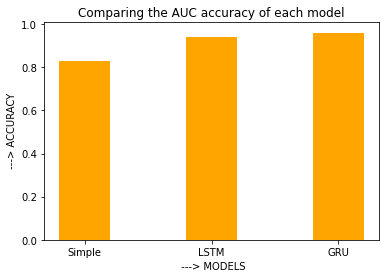

In [21]:
import numpy as np

import matplotlib.pyplot as plt

Accuracy = [0.83,0.94, 0.96]
Methods = ['Simple', 'LSTM', 'GRU']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy, width=0.4, color="orange")
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing the AUC accuracy of each model')
plt.xlabel(" ---> MODELS")
plt.ylabel(" ---> ACCURACY")
plt.show()

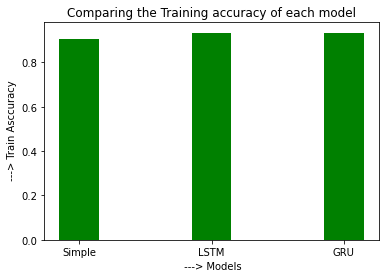

In [6]:
import matplotlib.pyplot as plt
Accuracy = [0.9079,0.9305, 0.9340]
Methods = ['Simple', 'LSTM', 'GRU']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy, width=0.3, color="green")
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing the Training accuracy of each model')
plt.xlabel(" ---> Models")
plt.ylabel(" ---> Train Accuracy")
plt.show()